<a href="https://colab.research.google.com/github/arimbawa/Aplikasi-IoT/blob/main/Minggu_4_Database_untuk_IoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Materi Minggu 4: Database untuk IoT**

**Tujuan Pembelajaran:**


1.   Mahasiswa memahami integrasi aplikasi IoT dengan database.
2.   Mahasiswa mampu membuat API Flask yang menyimpan dan mengambil data dari database.
3. Mahasiswa dapat menguji alur perangkat → Flask → Database → Visualisasi.

# Langkah Praktikum

1.   Setup Flask Server (Google Colab)

Kita pakai SQLite (ringan, sudah bawaan Python).

In [ ]:
!pip install flask pyngrok sqlalchemy
!pip install paho-mqtt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 1.4 MB/s eta 0:00:00


In [ ]:
from flask import Flask, request, jsonify
from pyngrok import ngrok
import paho.mqtt.client as mqtt
import json
import threading
import sqlite3
from datetime import datetime

# Replace "YOUR_NGROK_AUTH_TOKEN" with your actual ngrok authtoken
ngrok.set_auth_token("32tnIljunaDDrFMWVCD2784cERi_2tHAN1MwNfRM9Ug5omaq5")

# Buat app Flask
app = Flask(__name__)

# Database Setup
DATABASE = 'sensor_data.db'

def init_db():
    with app.app_context():
        db = get_db()
        cursor = db.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS mqtt_readings (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                light REAL,
                timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
            )
        ''')
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS http_readings (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                temperature REAL,
                humidity REAL,
                timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
            )
        ''')
        db.commit()

def get_db():
    db = getattr(g, '_database', None)
    if db is None:
        db = g._database = sqlite3.connect(DATABASE)
    return db

@app.teardown_appcontext
def close_db(error):
    db = getattr(g, '_database', None)
    if db is not None:
        db.close()

from flask import g

# MQTT Settings
MQTT_BROKER = "broker.hivemq.com"
MQTT_PORT = 1883
MQTT_TOPIC = "unram/iot/sensor"

# MQTT Callbacks
def on_connect(client, userdata, flags, rc):
    if rc == 0:
        print("Connected to MQTT Broker!")
        client.subscribe(MQTT_TOPIC)
        print(f"Subscribed to topic: {MQTT_TOPIC}")
    else:
        print(f"Failed to connect, return code {rc}\n")

def on_message(client, userdata, msg):
    print(f"Received `{msg.payload.decode()}` from `{msg.topic}` topic")
    try:
        data = json.loads(msg.payload.decode())
        # Assuming the MQTT message contains 'light' data
        if 'light' in data:
            light_value = data['light']
            with app.app_context():
                db = get_db()
                cursor = db.cursor()
                cursor.execute("INSERT INTO mqtt_readings (light) VALUES (?)", (light_value,))
                db.commit()
                print("Light data added to mqtt_readings table:", light_value)
        else:
            print("MQTT message does not contain 'light' data.")
    except json.JSONDecodeError:
        print("Failed to decode JSON from MQTT message.")
    except Exception as e:
        print(f"Error inserting MQTT data into database: {e}")


# Create MQTT Client
client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

# Connect to MQTT Broker in a separate thread
def connect_mqtt():
    client.connect(MQTT_BROKER, MQTT_PORT, 60)
    client.loop_forever()

mqtt_thread = threading.Thread(target=connect_mqtt)
mqtt_thread.start()


@app.route('/sensor', methods=['POST'])
def receive_sensor():
    data = request.json
    try:
        if 'temperature' in data and 'humidity' in data:
            temperature_value = data['temperature']
            humidity_value = data['humidity']
            db = get_db()
            cursor = db.cursor()
            cursor.execute("INSERT INTO http_readings (temperature, humidity) VALUES (?, ?)", (temperature_value, humidity_value))
            db.commit()
            print("Received temperature and humidity data via HTTP and added to http_readings table:", data)
            return jsonify({"status": "success", "received": data})
        else:
            print("HTTP data does not contain 'temperature' or 'humidity' data.")
            return jsonify({"status": "error", "message": "No 'temperature' or 'humidity' data in request"}), 400
    except Exception as e:
        print(f"Error inserting HTTP temperature and humidity data into database: {e}")
        return jsonify({"status": "error", "message": str(e)}), 500


@app.route('/data/light', methods=['GET'])
def get_light_data():
    db = get_db()
    cursor = db.cursor()

    cursor.execute("SELECT id, light, timestamp FROM mqtt_readings")
    mqtt_rows = cursor.fetchall()
    mqtt_data = []
    for row in mqtt_rows:
        mqtt_data.append({"id": row[0], "light": row[1], "timestamp": row[2], "source": "mqtt"})

    return jsonify({"mqtt_data": mqtt_data})

@app.route('/data/temp_hum', methods=['GET'])
def get_temp_hum_data():
    db = get_db()
    cursor = db.cursor()
    cursor.execute("SELECT id, temperature, humidity, timestamp FROM http_readings")
    http_rows = cursor.fetchall()
    http_data = []
    for row in http_rows:
        http_data.append({"id": row[0], "temperature": row[1], "humidity": row[2], "timestamp": row[3], "source": "http"})

    return jsonify({"http_data": http_data})

# Initialize the database
init_db()

# Buka tunnel ngrok di port 5000
public_url = ngrok.connect(5000).public_url
print("Flask server URL:", public_url)

# Jalankan Flask
if __name__ == '__main__':
    app.run(port=5000)

/tmp/ipython-input-2998652514.py:89: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


Connected to MQTT Broker!
Subscribed to topic: unram/iot/sensor
Flask server URL: https://98b22d332793.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:50:35] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 21.13, 'humidity': 56.75}


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:50:37] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 21.08, 'humidity': 48.68}


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:50:40] "POST /sensor HTTP/1.1" 200 -


Received `{"light": 871}` from `unram/iot/sensor` topic
Received `{"light": 871}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 871
Light data added to mqtt_readings table: 871
Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 23.57, 'humidity': 46.83}
Received `{"light": 213}` from `unram/iot/sensor` topic
Received `{"light": 213}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 213
Light data added to mqtt_readings table: 213


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:50:42] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 27.41, 'humidity': 49.28}
Received `{"light": 767}` from `unram/iot/sensor` topic
Received `{"light": 767}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 767
Light data added to mqtt_readings table: 767


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:50:44] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 23.86, 'humidity': 49.89}
Received `{"light": 423}` from `unram/iot/sensor` topicReceived `{"light": 423}` from `unram/iot/sensor` topic

Light data added to mqtt_readings table: 423
Light data added to mqtt_readings table: 423


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:50:46] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 22.41, 'humidity': 45.22}
Received `{"light": 146}` from `unram/iot/sensor` topicReceived `{"light": 146}` from `unram/iot/sensor` topic

Light data added to mqtt_readings table: 146
Light data added to mqtt_readings table: 146


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:50:49] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 20.17, 'humidity': 47.07}
Received `{"light": 963}` from `unram/iot/sensor` topic
Received `{"light": 963}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 963
Light data added to mqtt_readings table: 963


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:50:51] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 22.77, 'humidity': 40.21}
Received `{"light": 595}` from `unram/iot/sensor` topic
Received `{"light": 595}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 595
Light data added to mqtt_readings table: 595


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:50:53] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 22.47, 'humidity': 52.91}
Received `{"light": 164}` from `unram/iot/sensor` topic
Received `{"light": 164}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 164
Light data added to mqtt_readings table: 164


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:50:55] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 27.34, 'humidity': 40.31}
Received `{"light": 258}` from `unram/iot/sensor` topic
Received `{"light": 258}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 258
Light data added to mqtt_readings table: 258


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:50:58] "POST /sensor HTTP/1.1" 200 -


Received `{"light": 674}` from `unram/iot/sensor` topic
Received `{"light": 674}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 674
Light data added to mqtt_readings table: 674
Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 28.77, 'humidity': 49.04}
Received `{"light": 990}` from `unram/iot/sensor` topic
Received `{"light": 990}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 990
Light data added to mqtt_readings table: 990


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:00] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 26.92, 'humidity': 57.96}


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:00] "GET /data_light HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:01] "GET /favicon.ico HTTP/1.1" 404 -


Received `{"light": 1021}` from `unram/iot/sensor` topic
Received `{"light": 1021}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 1021
Light data added to mqtt_readings table: 1021


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:02] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 20.38, 'humidity': 43.42}


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:03] "GET /data_light HTTP/1.1" 404 -


Received `{"light": 687}` from `unram/iot/sensor` topic
Received `{"light": 687}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 687
Light data added to mqtt_readings table: 687


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:04] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 20.35, 'humidity': 51.15}
Received `{"light": 153}` from `unram/iot/sensor` topicReceived `{"light": 153}` from `unram/iot/sensor` topic

Light data added to mqtt_readings table: 153
Light data added to mqtt_readings table: 153


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:06] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 24.12, 'humidity': 53.37}
Received `{"light": 883}` from `unram/iot/sensor` topic
Received `{"light": 883}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 883
Light data added to mqtt_readings table: 883


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:09] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 21.09, 'humidity': 50.63}
Received `{"light": 45}` from `unram/iot/sensor` topicReceived `{"light": 45}` from `unram/iot/sensor` topic

Light data added to mqtt_readings table: 45
Light data added to mqtt_readings table: 45


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:11] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 24.79, 'humidity': 40.02}
Received `{"light": 826}` from `unram/iot/sensor` topic
Received `{"light": 826}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 826
Light data added to mqtt_readings table: 826


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:13] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 25.24, 'humidity': 42.14}
Received `{"light": 179}` from `unram/iot/sensor` topic
Received `{"light": 179}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 179
Light data added to mqtt_readings table: 179


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:15] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 20.39, 'humidity': 44.12}
Received `{"light": 147}` from `unram/iot/sensor` topic
Received `{"light": 147}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 147
Light data added to mqtt_readings table: 147


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:18] "POST /sensor HTTP/1.1" 200 -


Received `{"light": 348}` from `unram/iot/sensor` topic
Received `{"light": 348}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 348
Light data added to mqtt_readings table: 348
Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 26.52, 'humidity': 50.5}
Received `{"light": 13}` from `unram/iot/sensor` topic
Received `{"light": 13}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 13
Light data added to mqtt_readings table: 13


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:20] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 29.03, 'humidity': 57.25}


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:21] "GET /data/light HTTP/1.1" 200 -


Received `{"light": 25}` from `unram/iot/sensor` topic
Received `{"light": 25}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 25
Light data added to mqtt_readings table: 25


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:22] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 20.12, 'humidity': 49.07}


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:23] "GET /data/light HTTP/1.1" 200 -


Received `{"light": 534}` from `unram/iot/sensor` topicReceived `{"light": 534}` from `unram/iot/sensor` topic

Light data added to mqtt_readings table: 534
Light data added to mqtt_readings table: 534


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:24] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 22.88, 'humidity': 57.88}
Received `{"light": 65}` from `unram/iot/sensor` topic
Received `{"light": 65}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 65
Light data added to mqtt_readings table: 65


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:26] "GET /data/light HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:27] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 25.35, 'humidity': 56.94}
Received `{"light": 975}` from `unram/iot/sensor` topic
Received `{"light": 975}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 975
Light data added to mqtt_readings table: 975


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:29] "GET /data/light HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:29] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 27.99, 'humidity': 46.69}
Received `{"light": 1}` from `unram/iot/sensor` topic
Received `{"light": 1}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 1
Light data added to mqtt_readings table: 1


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:31] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 24.08, 'humidity': 54.39}
Received `{"light": 256}` from `unram/iot/sensor` topic
Received `{"light": 256}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 256
Light data added to mqtt_readings table: 256


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:33] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 29.04, 'humidity': 51.48}
Received `{"light": 99}` from `unram/iot/sensor` topic
Received `{"light": 99}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 99
Light data added to mqtt_readings table: 99


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:35] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 21.63, 'humidity': 46.38}
Received `{"light": 423}` from `unram/iot/sensor` topic
Received `{"light": 423}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 423
Light data added to mqtt_readings table: 423
Received `{"light": 971}` from `unram/iot/sensor` topic
Received `{"light": 971}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 971
Light data added to mqtt_readings table: 971


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:38] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 28.66, 'humidity': 50.17}
Received `{"light": 176}` from `unram/iot/sensor` topic
Received `{"light": 176}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 176
Light data added to mqtt_readings table: 176


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:40] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 22.15, 'humidity': 40.76}
Received `{"light": 71}` from `unram/iot/sensor` topic
Received `{"light": 71}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 71
Light data added to mqtt_readings table: 71


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:42] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 26.33, 'humidity': 53.05}
Received `{"light": 613}` from `unram/iot/sensor` topic
Received `{"light": 613}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 613
Light data added to mqtt_readings table: 613


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:44] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 21.85, 'humidity': 47.67}
Received `{"light": 776}` from `unram/iot/sensor` topic
Received `{"light": 776}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 776
Light data added to mqtt_readings table: 776


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:47] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 29.9, 'humidity': 58.49}
Received `{"light": 656}` from `unram/iot/sensor` topic
Received `{"light": 656}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 656
Light data added to mqtt_readings table: 656


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:49] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 28.51, 'humidity': 43.58}


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:49] "GET /data/temp_hum HTTP/1.1" 200 -


Received `{"light": 919}` from `unram/iot/sensor` topic
Received `{"light": 919}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 919
Light data added to mqtt_readings table: 919


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:51] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 28.53, 'humidity': 46.26}
Received `{"light": 336}` from `unram/iot/sensor` topic
Received `{"light": 336}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 336
Light data added to mqtt_readings table: 336


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:52] "GET /data/temp_hum HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:53] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 27.03, 'humidity': 40.25}
Received `{"light": 918}` from `unram/iot/sensor` topic
Received `{"light": 918}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 918
Light data added to mqtt_readings table: 918


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:56] "POST /sensor HTTP/1.1" 200 -


Received `{"light": 838}` from `unram/iot/sensor` topic
Received `{"light": 838}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 838
Light data added to mqtt_readings table: 838
Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 21.15, 'humidity': 42.09}
Received `{"light": 225}` from `unram/iot/sensor` topic
Received `{"light": 225}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 225
Light data added to mqtt_readings table: 225


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:51:58] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 21.21, 'humidity': 42.39}
Received `{"light": 689}` from `unram/iot/sensor` topic
Received `{"light": 689}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 689
Light data added to mqtt_readings table: 689


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:52:00] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 24.64, 'humidity': 59.43}
Received `{"light": 209}` from `unram/iot/sensor` topicReceived `{"light": 209}` from `unram/iot/sensor` topic

Light data added to mqtt_readings table: 209
Light data added to mqtt_readings table: 209


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:52:02] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 27.25, 'humidity': 55.97}
Received `{"light": 647}` from `unram/iot/sensor` topicReceived `{"light": 647}` from `unram/iot/sensor` topic

Light data added to mqtt_readings table: 647
Light data added to mqtt_readings table: 647


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:52:04] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 20.46, 'humidity': 52.99}
Received `{"light": 985}` from `unram/iot/sensor` topic
Received `{"light": 985}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 985
Light data added to mqtt_readings table: 985


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:52:07] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 26.42, 'humidity': 44.97}
Received `{"light": 166}` from `unram/iot/sensor` topic
Received `{"light": 166}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 166
Light data added to mqtt_readings table: 166


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:52:09] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 25.69, 'humidity': 57.4}
Received `{"light": 690}` from `unram/iot/sensor` topic
Received `{"light": 690}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 690
Light data added to mqtt_readings table: 690


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:52:11] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 22.89, 'humidity': 43.67}
Received `{"light": 166}` from `unram/iot/sensor` topicReceived `{"light": 166}` from `unram/iot/sensor` topic

Light data added to mqtt_readings table: 166
Light data added to mqtt_readings table: 166


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:52:13] "POST /sensor HTTP/1.1" 200 -


Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 22.44, 'humidity': 59.59}
Received `{"light": 463}` from `unram/iot/sensor` topic
Received `{"light": 463}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 463
Light data added to mqtt_readings table: 463


INFO:werkzeug:127.0.0.1 - - [19/Sep/2025 07:52:16] "POST /sensor HTTP/1.1" 200 -


Received `{"light": 871}` from `unram/iot/sensor` topic
Received `{"light": 871}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 871
Light data added to mqtt_readings table: 871
Received temperature and humidity data via HTTP and added to http_readings table: {'temperature': 20.51, 'humidity': 51.6}
Received `{"light": 542}` from `unram/iot/sensor` topic
Received `{"light": 542}` from `unram/iot/sensor` topic
Light data added to mqtt_readings table: 542
Light data added to mqtt_readings table: 542


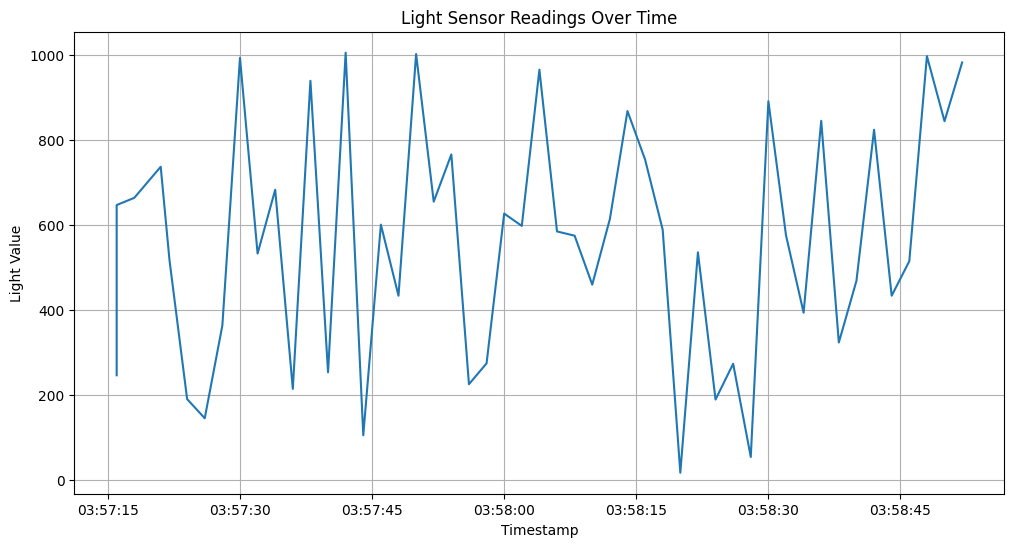

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

DATABASE = 'sensor_data.db'

def get_light_data():
    conn = None
    try:
        conn = sqlite3.connect(DATABASE)
        cursor = conn.cursor()
        cursor.execute("SELECT light, timestamp FROM mqtt_readings ORDER BY timestamp")
        rows = cursor.fetchall()
        return rows
    except Exception as e:
        print(f"Error retrieving light data: {e}")
        return None
    finally:
        if conn:
            conn.close()

light_data = get_light_data()

if light_data:
    df = pd.DataFrame(light_data, columns=['light', 'timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['light'])
    plt.xlabel("Timestamp")
    plt.ylabel("Light Value")
    plt.title("Light Sensor Readings Over Time")
    plt.grid(True)
    plt.show()
else:
    print("No light data available to plot.")

To use `pyngrok`, you need to get an authtoken from the ngrok dashboard ([https://dashboard.ngrok.com/get-started/your-authtoken](https://dashboard.ngrok.com/get-started/your-authtoken)). Once you have it, you can add it to the code using `ngrok.set_auth_token()`.

Setelah dijalankan, akan muncul URL publik https://xxxxx.ngrok.io → endpoint ini akan dipakai oleh client (HTTP/MQTT).

# Output yang Diharapkan

1. Data sensor berhasil disimpan di SQLite melalui Flask.

2. Endpoint /data menampilkan list JSON data sensor.

3. Mahasiswa memahami bagaimana server IoT menyimpan data sensor untuk analisis lebih lanjut.